<h1>Projekt LIA: Preklad do fínčiny</h1>

<h3>Fínčina</h3>
<ul><li>veľký počet pádov</li><li>na pomedzí flektívnych a aglutinačných jazykov</li><li>používa latinku s diakritikou</li></ul>

<h3>Metóda:</h3>
<p>Určenie predpokladaných kandidátov na preklad:</p>
<ol> <li>Analýza frekvencií možných slov a morfémov</li>
<li>Reverzné testovanie prekladu</li>
<li>Výsledky</li></ol>

<h3>Nástroje:</h3>
<ul> <li>ČNK (CQL query: [lemma="máslo" & tag="N.{3}1.*"])</li>
<li> ČNK API (https://github.com/czcorpus/kontext/wiki/HTTP-API)</li>
<li>Python</li></ul>

<h3>Stanovenie konštánt</h3>

In [101]:
TOP_K = 30
WORD_LIMIT = 20
WHITE_SPACE_SYMBOLS = " .,!?;()"

<h1>Morfémy</h1>
Určenie prekladu jedného slova vo fínčine je zložité pre veľké množstvo morfémov; budeme sa teda snažiť nájsť priesečník medzi morfémami a slovami.
<h3>Predpoklady</h3>
<ul>
<li>morfém - krátky ngram zo znakov</li>
<li>slovo - reťazec znakov vymedzený medzerou alebo white space symbolom</li>
</ul>

<h3>Nahratie dát</h3>
Dáta sú získané zo zarovnaných korpusov dostupných na ČNK: InterCorp v16 - Finnish, InterCorp v16 Czech

Stiahnuté dáta vo formáte xlsx nahráme pomocou pandas

In [102]:
import pandas as pd
corpus_data = pd.read_excel("korpus.xlsx", header=None)
corpus_data[0] = corpus_data.iloc[:, 1:5].astype(str).apply(' '.join, axis=1)
corpus_data = corpus_data.drop(columns=[1,2,3,4,5])
corpus_data.columns = ["cz", "fn"]
corpus_data.head()

,cz,fn
0,Co je Arašídový strom a Arašídové máslo ? _SUB...,Sitten riennän koulunäytelmiin- runoiltoihin j...
1,Arašídové máslo . _SUBTITLES,Maapähkinävoita .
2,Řezník byl jako máslo . _SUBTITLES,Teurastaja oli kuin sulaa voita .
3,"d ) popřípadě chladírenský sklad , v němž je m...","d ) tarvittaessa kylmävarasto , jossa voita sä..."
4,"A když se tě zeptají , jestli je to máslo prav...","Jos he kysyvät , onko se oikeaa voita , mitä v..."


<h3>Extrakcia morfémov</h3>
Extrahujeme všetky potenciálne morfémy do prednastavenej dĺžky


Načítanie všetkých textov

In [103]:
finnish_text = " ".join(corpus_data["fn"])
czech_text = " ".join(corpus_data["cz"])

Extrakcia morfémov

In [104]:
from collections import Counter
from functools import reduce

def find_white_space_symbols(string):
  found = []
  for white_space in WHITE_SPACE_SYMBOLS:
    found.append(string.find(white_space) == -1)
  return not reduce(lambda x, y: x*y, found)

def find_ngrams(text, n):
    ngrams = [text[i:i+n] for i in range(len(text)-n+1) if not find_white_space_symbols(text[i:i+n])]
    return ngrams

def most_frequent_ngrams(text, n, top_k=5):
    ngrams = find_ngrams(text, n)
    ngram_counts = Counter(ngrams)
    return ngram_counts.most_common(top_k)

morphemes = dict()
shortest_morpheme = 2
longest_morpheme = 10
for morpheme_length in range(shortest_morpheme, longest_morpheme):
  for word, freq in most_frequent_ngrams(finnish_text, morpheme_length, TOP_K):
    word = word.lower().strip()
    if word in morphemes:
      morphemes[word] += freq
    else:
      morphemes[word] = freq
possible_morpheme_translations = sorted(morphemes.items(), key=lambda item: item[1], reverse=True)
limited_possible_morpheme_translations = possible_morpheme_translations[:WORD_LIMIT]

<h3>Ukážka extrahovaných dát</h3>


In [105]:
morphs = [data_entry[0] for data_entry in possible_morpheme_translations]
freqs = [data_entry[1] for data_entry in possible_morpheme_translations]

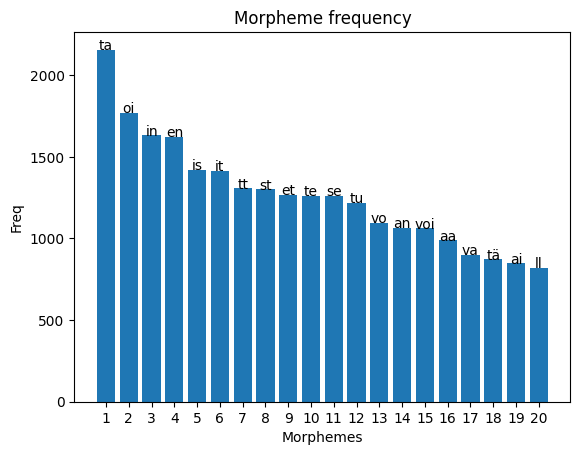

In [106]:
import matplotlib.pyplot as plt
plt.bar([str(index + 1) for index in range(WORD_LIMIT)], freqs[:WORD_LIMIT])
plt.xlabel('Morphemes')
plt.ylabel('Freq')
plt.title('Morpheme frequency')
for index, (word, freq) in enumerate(possible_morpheme_translations[:WORD_LIMIT]):
    plt.text(index, freq + .2, word, ha='center')
plt.show()

In [107]:
def get_num_hits(corpus_data, string, corpus_data_key="fn"):
  return corpus_data[corpus_data_key].apply(lambda sent: sent.find(string) >= 0).sum()

morphemes_df = dict()
for morpheme, freq in limited_possible_morpheme_translations:
  morphemes_df[morpheme] = get_num_hits(corpus_data, morpheme), freq

morphemes_df = pd.DataFrame.from_dict(morphemes_df).transpose()
morphemes_df.columns = ["num_of_lines", "freq"]
morphemes_df.sort_values(by="freq", ascending=False).head(TOP_K)

,num_of_lines,freq
ta,675,2156
oi,789,1769
in,643,1631
en,405,1622
is,437,1419
it,637,1414
tt,432,1307
st,424,1300
et,370,1267
se,357,1259


<h1>Slová</h1>



<h3>Extrakcia slov</h3>


In [108]:
def get_words_freqs(text):
    words = [word for word in text.split() if word not in WHITE_SPACE_SYMBOLS]
    words_counter = Counter(words)
    return words_counter

word_frequencies = get_words_freqs(finnish_text)
possible_word_translations = word_frequencies.most_common(TOP_K)
words_df = dict()
for word, freq in possible_word_translations:
  words_df[word] = get_num_hits(corpus_data, " " + word + " "), freq

words_df = pd.DataFrame.from_dict(words_df).transpose()
words_df.columns = ["num_of_lines", "freq"]
words_df.sort_values(by="freq", ascending=False).head(TOP_K)

,num_of_lines,freq
ja,312,463
on,315,370
voi,198,218
voita,158,170
N:o,94,155
"""",50,143
-,48,141
voin,114,127
1,84,127
artiklan,90,123


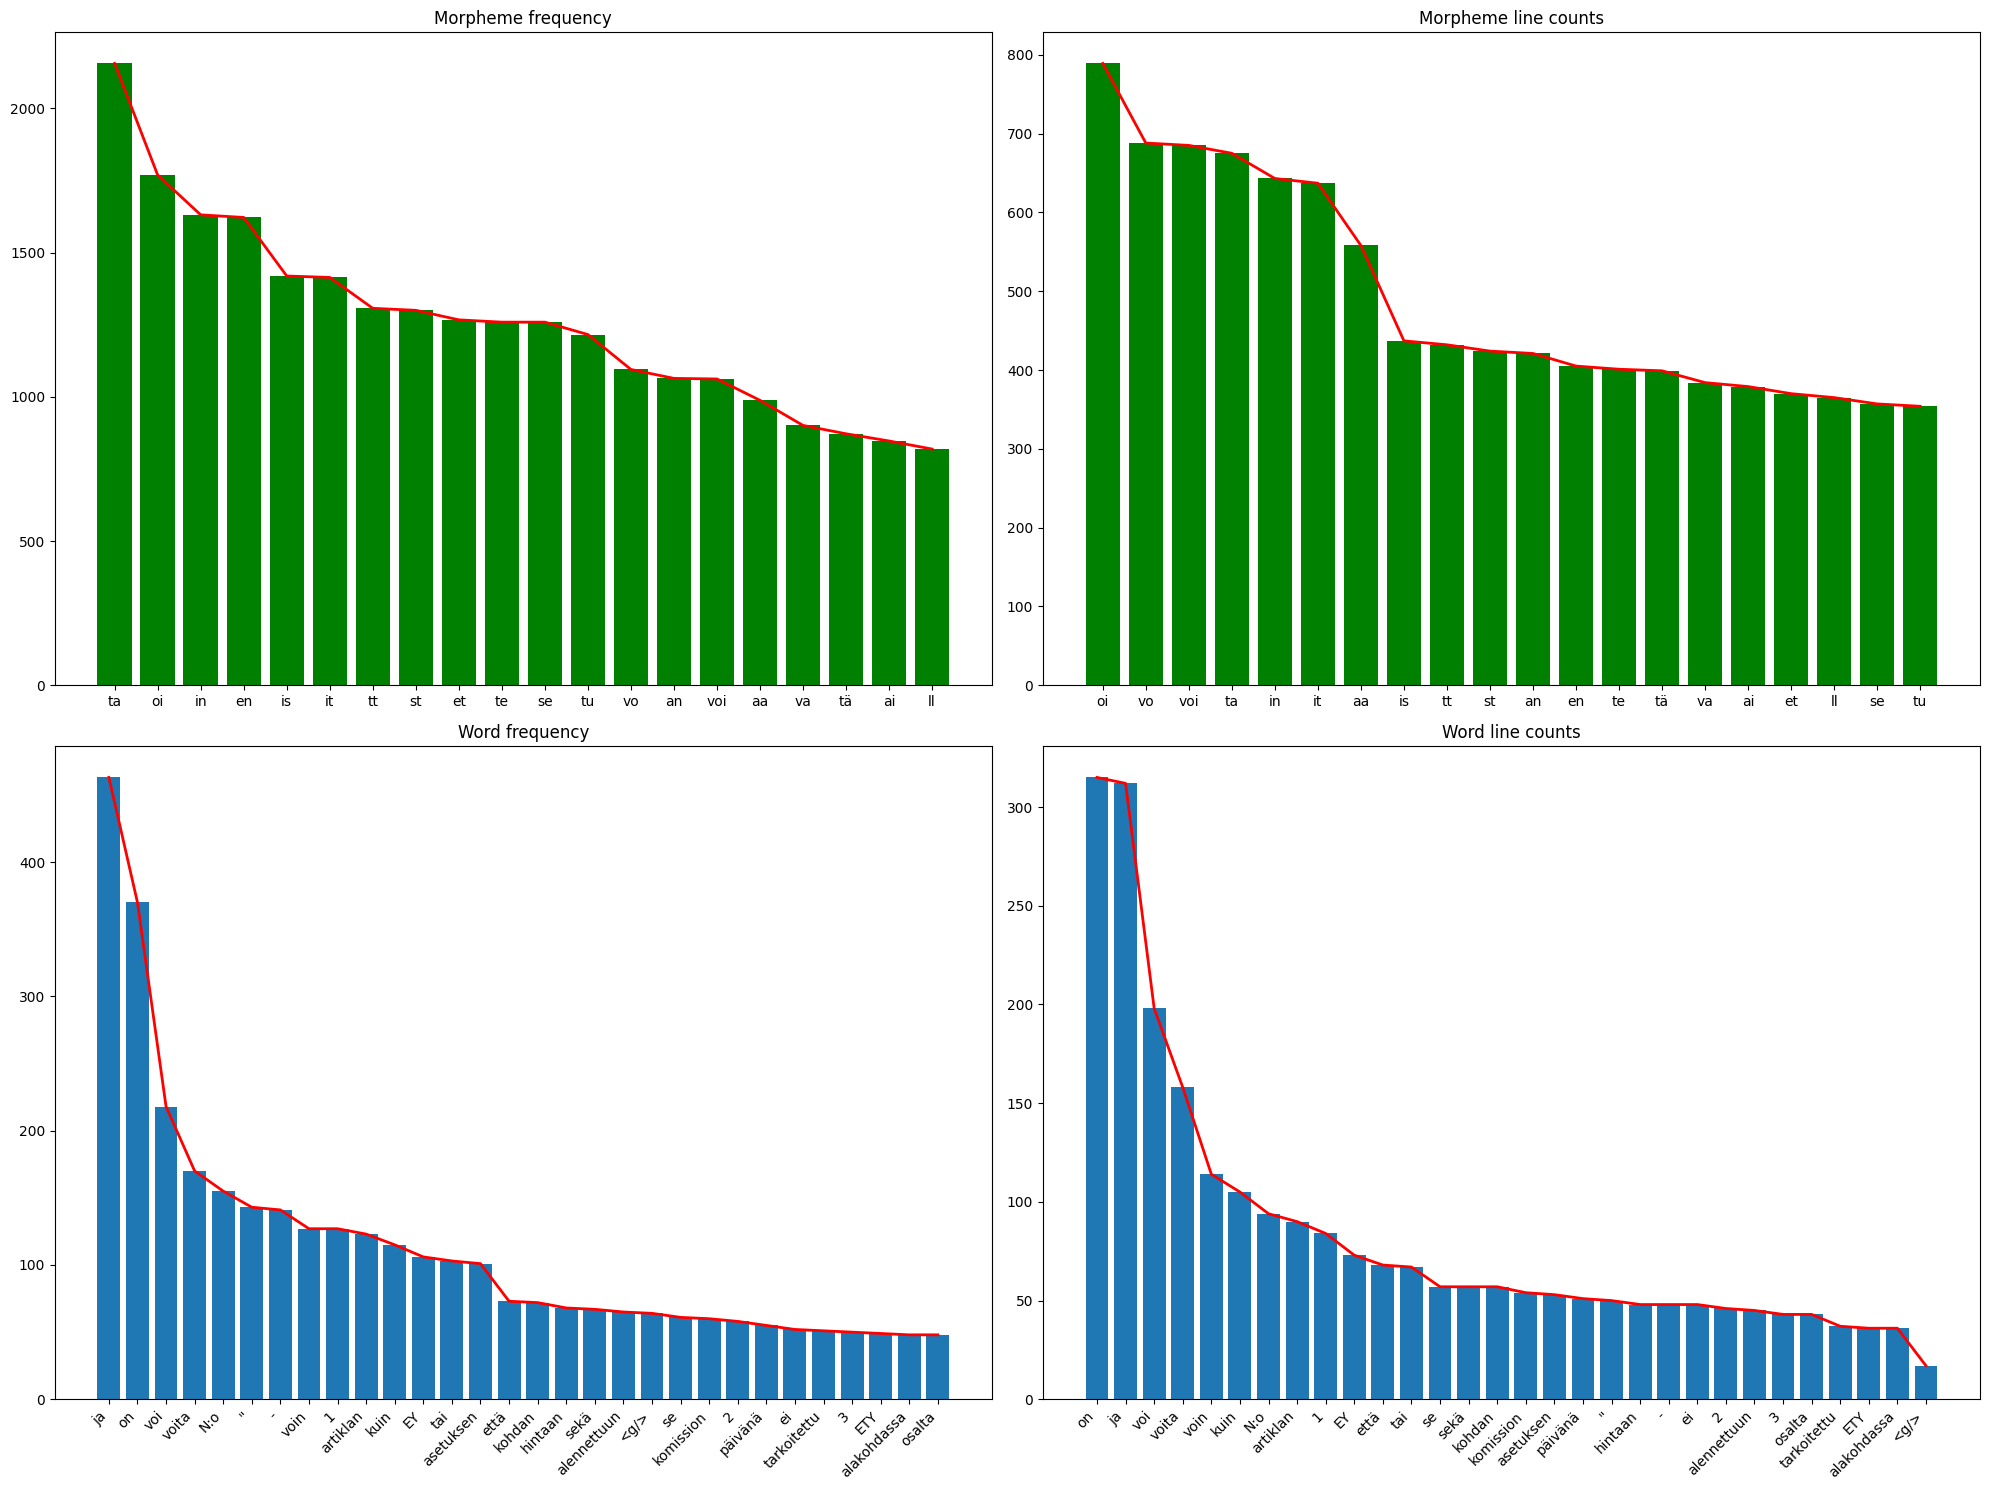

In [109]:
def create_histos(axes, morphemes_df, words_df):
  x, y = list(morphemes_df["freq"].keys()), list(morphemes_df["freq"].values)
  axes[0][0].bar(x, y, color="green")
  axes[0][0].set_title('Morpheme frequency')
  axes[0][0].plot(x, y, color='red', linewidth=2)
  x = list(morphemes_df.sort_values(by="num_of_lines", ascending=False)["num_of_lines"].keys())
  y = list(morphemes_df.sort_values(by="num_of_lines", ascending=False)["num_of_lines"].values)
  axes[0][1].bar(x, y, color="green")
  axes[0][1].set_title('Morpheme line counts')
  axes[0][1].plot(x, y, color='red', linewidth=2)
  x, y = list(words_df["freq"].keys()), list(words_df["freq"].values)
  axes[1][0].bar(x, y)
  axes[1][0].set_xticks(x)
  axes[1][0].set_xticklabels(x, rotation=45, ha='right')
  axes[1][0].set_title('Word frequency')
  axes[1][0].plot(x, y, color='red', linewidth=2)
  x = list(words_df.sort_values(by="num_of_lines", ascending=False)["num_of_lines"].keys())
  y = list(words_df.sort_values(by="num_of_lines", ascending=False)["num_of_lines"].values)
  axes[1][1].bar(x, y)
  axes[1][1].set_xticks(x)
  axes[1][1].set_xticklabels(x, rotation=45, ha='right')
  axes[1][1].set_title('Word line counts')
  axes[1][1].plot(x, y, color='red', linewidth=2)
  return

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
create_histos(axes, morphemes_df, words_df)
plt.tight_layout()
plt.show()

<h1>Morfoslová</h1>
morfoslovo - prienik množín morfémov a slov


In [110]:
morph_words = set.intersection(set([morph[0] for morph in possible_morpheme_translations]),
                               set([word[0] for word in possible_word_translations]))
morph_words

{'artiklan', 'asetuksen', 'ja', 'komission', 'on', 'se', 'voi', 'voita'}

In [111]:
butter_line_freq = corpus_data.shape[0]
butter_freq = get_words_freqs(czech_text)["máslo"]

In [112]:
morph_words_df = dict()
for morph_word in morph_words:
  try:
    info = morphemes_df.loc[morph_word]
  except:
    info =  words_df.loc[morph_word]
  morph_words_df[morph_word] = {"num_of_lines": info[0],
                                "num_of_lines_relative": info[0]/butter_line_freq,
                                "freq": info[1],
                                "freq_relative": info[1] / butter_freq}

morph_words_df

{'se': {'num_of_lines': 357,
  'num_of_lines_relative': 0.3781779661016949,
  'freq': 1259,
  'freq_relative': 1.2223300970873787},
 'on': {'num_of_lines': 315,
  'num_of_lines_relative': 0.3336864406779661,
  'freq': 370,
  'freq_relative': 0.3592233009708738},
 'artiklan': {'num_of_lines': 90,
  'num_of_lines_relative': 0.09533898305084745,
  'freq': 123,
  'freq_relative': 0.11941747572815534},
 'asetuksen': {'num_of_lines': 53,
  'num_of_lines_relative': 0.05614406779661017,
  'freq': 101,
  'freq_relative': 0.09805825242718447},
 'voi': {'num_of_lines': 685,
  'num_of_lines_relative': 0.725635593220339,
  'freq': 1062,
  'freq_relative': 1.0310679611650486},
 'ja': {'num_of_lines': 312,
  'num_of_lines_relative': 0.3305084745762712,
  'freq': 463,
  'freq_relative': 0.4495145631067961},
 'komission': {'num_of_lines': 54,
  'num_of_lines_relative': 0.057203389830508475,
  'freq': 60,
  'freq_relative': 0.05825242718446602},
 'voita': {'num_of_lines': 158,
  'num_of_lines_relative':

<h1>Kontrola výsledkov</h1>


<h3>ČNK API request</h3>
<ul><li> pred vykonaním tohto kroku je potrebné si zdarma aktivovať vlastný prístupový kľúč k API podľa návodu: https://wiki.korpus.cz/doku.php/manualy:api</li></ul>

In [113]:
personal_access_token = "YOUR_VERY_SPECIAL_API_KEY"

Nastavenie korpusov

In [114]:
czech_corpus_name= "intercorp_v16_cs"
finnish_corpus_name="intercorp_v16_fi"
original_query = "[lemma=\"máslo\" & tag=\"N.{3}1.*\"]"
MAX_NUM_RESULTS = 4*corpus_data.shape[0]
FIRST_N_PAGES = 1

Funkcia na posielanie API requestov

In [115]:
import pickle, requests
cookies_file = 'cookies.pickle'

def load_cookies(s):
  try:
      with open(cookies_file, 'rb') as f:
          s.cookies.update(pickle.load(f))
  except FileNotFoundError:
      pass
  return s

def generate_request_body(corpusA, corpusB, query, fromp=0):
  request_body = {
        "type": "concQueryArgs",
        "maincorp": corpusA,
        "usesubcorp": None,
        "viewmode": "align",
        "pagesize": 100,
        "attrs": "word",
        "attr_vmode": "visible-kwic",
        "base_viewattr": "word",
        "ctxattrs": [],
        "structs": ["text","p","g"],
        "refs": [],
        "fromp": fromp,
        "shuffle": 1, #premiesaj riadky
        "queries": [
            {
                "qtype": "advanced",
                "corpname": corpusA,
                "query": query,
                "pcq_pos_neg": "pos",
                "include_empty": False,
                "default_attr": "word"
            },{
                "qtype": "simple",
                "corpname": corpusB,
                "query": "",
                "pcq_pos_neg": "pos",
                "include_empty": False,
                "default_attr": "word"
            }
        ],
        "text_types": {},
        "context":
        {
            "fc_lemword_wsize": [-5, 5],
            "fc_lemword": "",
            "fc_lemword_type": "all",
            "fc_pos_wsize": [-5, 5],
            "fc_pos": [],
            "fc_pos_type": "all"
        },
        "async": False
    }
  return request_body


def get_corpus_data(corpusA, corpusB, query, fromp=0):
  with requests.Session() as s:
    s = load_cookies(s)
    r = s.post('https://korpus.cz/login', data={'personal_access_token': personal_access_token})
    request_body = generate_request_body(corpusA, corpusB, query, fromp)
    r = s.post('https://korpus.cz/kontext-api/v0.17/query_submit', params={'format': 'json'}, json=request_body)
    response_json = r.json()
    conc_persistence_op_id = response_json['conc_persistence_op_id']
    r = s.get('https://korpus.cz/kontext-api/v0.17/view',
              params={'format': 'json', 'q': '~' +conc_persistence_op_id,
                      'pagesize': MAX_NUM_RESULTS, 'viewmode':'align'})

    with open(cookies_file, 'wb') as f: #save cookie
      pickle.dump(s.cookies, f)
    return r

In [116]:
maslo_responses = [get_corpus_data(czech_corpus_name,finnish_corpus_name, original_query, i) for i in range(FIRST_N_PAGES)]
def get_align_sents(rs):
  aligned_sents = []
  for r in rs:
    try:
      parsed_response = r.json()
      for line in parsed_response["Lines"]:
        aligned_sents.append(line["Align"][0]["Kwic"][0]["str"])
    except:
      pass
  return aligned_sents

maslo_aligned = get_align_sents(maslo_responses)

In [117]:
print("Počet fínskych paralelných viet: ", len(maslo_aligned))
print("Ukážka:\n" + "\n".join(maslo_aligned[:4]))

Počet fínskych paralelných viet:  944
Ukážka:
Sitten riennän koulunäytelmiin- runoiltoihin ja esitelmiin .
Maapähkinävoita .
Teurastaja oli kuin sulaa voita .
d ) tarvittaessa kylmävarasto , jossa voita säilytetään , ja mahdollisesti korvaava varasto ;


<h3>Krížova kontrola prekladu pomocou API request</h3>

In [118]:
QUERY_TYPE = "lemma"
translations = dict()
morph_words = list(morph_words)

In [119]:
for morph_word in morph_words:
  translation_query = f"[{QUERY_TYPE}=\"{morph_word}\"]"
  print(f"Querying corpus with query: {translation_query}")
  translations_corpus = [get_corpus_data(finnish_corpus_name, czech_corpus_name, translation_query) for i in range(FIRST_N_PAGES)]
  translations_aligned = list(set(get_align_sents(translations_corpus)))
  print(f"{len(translations_aligned)} results retrieved")
  translations[morph_word] = translations_aligned

Querying corpus with query: [lemma="se"]
3754 results retrieved
Querying corpus with query: [lemma="on"]
2682 results retrieved
Querying corpus with query: [lemma="artiklan"]
0 results retrieved
Querying corpus with query: [lemma="asetuksen"]
0 results retrieved
Querying corpus with query: [lemma="voi"]
2783 results retrieved
Querying corpus with query: [lemma="ja"]
3766 results retrieved
Querying corpus with query: [lemma="komission"]
5 results retrieved
Querying corpus with query: [lemma="voita"]
391 results retrieved


<h3>Kontrola frekvencie výskytu slova maslo pre jednotlivých kandidátov prekladu</h3>

In [120]:
WORD_SUFFIX_LEN = 1

def get_target_word_freq(translations, word):
  freqs = dict()
  word_stem = word[:len(word) - WORD_SUFFIX_LEN]
  print("Základný tvar slova: "  + word)
  print("Umelý kmeň slova: " + word_stem)
  for morphword, sents in translations.items():
    lc = sum([word_stem in sent  for sent in sents])
    sents_str = " ".join(sents).strip().lower()
    wf = get_words_freqs(sents_str)[word]
    mf = Counter(find_ngrams(sents_str, len(word_stem)))[word_stem]
    rlc = lc/len(sents) if len(sents) else 0
    rmf = mf/len(sents) if len(sents) else 0
    freqs[morphword] = (wf, mf, lc, rmf, rlc)
    print("Počet výskytov v paralelných vetách pre morfoslovo "+ morphword)
    print("Kmeň ako morfém:",mf,"Slovo ako slovo:", wf, sep="\t")
    print(f"Relatívne zastúpenie slova {word} ", rmf, sep="\t")
    print(f"Počet riadkov so slovom/kmeňom: {word}/{word_stem}", lc, sep="\t")
    print(f"Relatívny počet riadkov: ", rlc, sep="\t")
    print()
  return freqs
translation_frequencies = get_target_word_freq(translations, "máslo")

Základný tvar slova: máslo
Umelý kmeň slova: másl
Počet výskytov v paralelných vetách pre morfoslovo se
Kmeň ako morfém:	1	Slovo ako slovo:	0
Relatívne zastúpenie slova máslo 	0.0002663825253063399
Počet riadkov so slovom/kmeňom: máslo/másl	1
Relatívny počet riadkov: 	0.0002663825253063399

Počet výskytov v paralelných vetách pre morfoslovo on
Kmeň ako morfém:	0	Slovo ako slovo:	0
Relatívne zastúpenie slova máslo 	0.0
Počet riadkov so slovom/kmeňom: máslo/másl	0
Relatívny počet riadkov: 	0.0

Počet výskytov v paralelných vetách pre morfoslovo artiklan
Kmeň ako morfém:	0	Slovo ako slovo:	0
Relatívne zastúpenie slova máslo 	0
Počet riadkov so slovom/kmeňom: máslo/másl	0
Relatívny počet riadkov: 	0

Počet výskytov v paralelných vetách pre morfoslovo asetuksen
Kmeň ako morfém:	0	Slovo ako slovo:	0
Relatívne zastúpenie slova máslo 	0
Počet riadkov so slovom/kmeňom: máslo/másl	0
Relatívny počet riadkov: 	0

Počet výskytov v paralelných vetách pre morfoslovo voi
Kmeň ako morfém:	202	Slovo ako

In [121]:
results_df = pd.DataFrame.from_dict(translation_frequencies).transpose().drop(0, axis=1)
results_df.columns = ["TWfreq", "TWline_freq", "cross_rel_freq", "cross_rel_line_freq"]

In [122]:
results_df["translation_validityLine"] = results_df["cross_rel_freq"] / results_df["cross_rel_freq"].sum()
results_df["translation_validityFreq"] = results_df["cross_rel_line_freq"] / results_df["cross_rel_line_freq"].sum()

In [123]:
results_df.sort_values(by="translation_validityLine", ascending=False)

,TWfreq,TWline_freq,cross_rel_freq,cross_rel_line_freq,translation_validityLine,translation_validityFreq
voita,62.0,51.0,0.158568,0.130435,0.678969,0.748115
voi,202.0,120.0,0.072584,0.043119,0.310794,0.247311
ja,8.0,2.0,0.002124,0.000531,0.009096,0.003046
se,1.0,1.0,0.000266,0.000266,0.001141,0.001528
on,0.0,0.0,0.000000,0.000000,0.000000,0.000000
artiklan,0.0,0.0,0.000000,0.000000,0.000000,0.000000
asetuksen,0.0,0.0,0.000000,0.000000,0.000000,0.000000
komission,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [124]:
((results_df["translation_validityLine"] +
  results_df["translation_validityFreq"])/2).round(2) # translation_test

se           0.00
on           0.00
artiklan     0.00
asetuksen    0.00
voi          0.28
ja           0.01
komission    0.00
voita        0.71
dtype: float64